**Author:** [Giuseppe Muschetta](https://github.com/peppe212)
**Python version:** 3.11

## DATA UNDERSTANDING AND PREPARATION
### also done Regression using a Linear Regressor and a DecisionTree Regressor

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import (
    when, 
    count, 
    isnull, 
    lit, 
    col, 
    lower,
    min,
    max,
    desc,
    abs,
)
from pyspark.ml.feature import StandardScaler, VectorAssembler
from pyspark.ml.regression import LinearRegression, DecisionTreeRegressor
from pyspark.ml.stat import Correlation
from pyspark.ml import Pipeline

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
input_dataset_path = "./dataset/earthquakes.csv"
images_path = "./images/understanding/"
output_dataset_path = "./dataset/earthquakes_prepared" # estensione omessa appositamente

In [4]:
# INIZIA LA SESSIONE SPARK
spark = (SparkSession
         .builder
         .master('local[*]')
         .appName("Project")
         #.config("spark.driver.memory", "4g")
         .getOrCreate())

# sopprime i fastidiosissimi warning
spark.sparkContext.setLogLevel("ERROR")

# visualizza la sessione spark attiva
spark

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/12/02 20:44:13 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
23/12/02 20:44:13 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [5]:
df = spark.read.option("escape","\"").csv(input_dataset_path, header=True, inferSchema=True)
# il dataset è possibile reperirlo al seguente link:
# https://www.kaggle.com/datasets/danielpe/earthquakes
# dati mondiali raccolti dal 1970 al 2019

## Data Understanding

#### Info dataset columns

**_c0**: Automatically generated index

**textbf**: Usually the date and time when the earthquake occurred. 
This can be in various formats, such as UTC (Coordinated Universal Time).

**latitude**: The geographical latitude where the earthquake occurred. 
It's a measure in degrees, where values can range from -90 (the South Pole) to +90 (the North Pole).

**longitude**: The geographical longitude where the earthquake occurred. It is measured in degrees, with values 
ranging from -180 to +180, indicating the position east or west of the Prime Meridian.

**depth**: The depth at which the earthquake originated below the earth's surface, 
typically measured in kilometers. Shallower earthquakes often cause more damage.

**mag**: A number that characterizes the relative size or energy release of an earthquake. 
There are various scales, like the Richter scale or moment magnitude scale (Mw), 
with higher numbers indicating stronger earthquakes.

**magType**: Indicates the method or scale used to calculate the magnitude of the earthquake 
(e.g., Mw for moment magnitude, ML for local magnitude, etc.).

**nst**: This stands for "Number of Stations Used." It refers to the number of seismic stations that 
were used to record the earthquake. A higher number usually indicates that the earthquake's 
location and magnitude have been recorded with more accuracy.

**gap**: This term typically refers to the "Azimuthal Gap", which is the largest angle between two adjacent 
stations as seen from the earthquake's epicenter. It is measured in degrees. 
A smaller gap generally indicates a better-sampled earthquake, 
leading to more accurate determination of the earthquake's location and depth.   

**dmin**: This is the shortest horizontal distance from the epicenter to the nearest station, usually measured in degrees. 
In some cases, it can be measured in kilometers. A smaller DMIN value may indicate higher 
accuracy in the earthquake's recorded data, as the seismic waves have less distance 
to travel and are less likely to be altered.

**rms**: This stands for "Root Mean Square." In the context of earthquakes, 
it usually refers to the root-mean-square of the time residuals of the arrivals of seismic waves at 
different stations. Essentially, it's a measure of the accuracy of the timing of the seismic waves 
at different stations. A lower RMS value indicates a better fit to the seismic data and, hence, a more 
accurately determined earthquake location.

**net**: This generally stands for "Network" and identifies the seismic network that provided the 
data or the network code. Different networks can have varying equipment and standards for measuring earthquakes, 
so this code can be useful for understanding the potential variability in the data.

**id**: A unique identifier for each earthquake event, often assigned by the reporting agency.

**updated**: This usually refers to the timestamp of the last update made to the record. 
Earthquake data can be revised as new information becomes available, so this field helps track the most recent data.

**place**: A textual description of the location where the earthquake occurred. 
This is often a more user-friendly location name, such as a nearby city or geographical feature.

**type**: This field typically indicates the type of seismic event. While most events are earthquakes, 
this field can also contain values like 'quarry blast', 'explosion', or 'sonic boom' among others.

**horizontalError**: This refers to the uncertainty or error in the reported location of the earthquake’s epicenter, measured horizontally. 
It's usually given in kilometers. A smaller horizontal error indicates more precise location determination.

**depthError**: Similar to horizontal error, this is the uncertainty or error in the depth measurement of the earthquake, 
also typically measured in kilometers. A smaller depth error suggests more accurate depth determination. 

**magError**: This is the error associated with the magnitude measurement of the earthquake. 
A smaller magnitude error indicates higher confidence in the reported magnitude.

**magNst**: Stands for "Magnitude Number of Stations." It refers to the number of seismic stations used to calculate 
the earthquake’s magnitude. Like NST, a higher number here usually suggests a more accurately determined magnitude.

**status**: This field often indicates the review status of the earthquake record. Common values include 'automatic' 
for initially computer-generated records and 'reviewed' for records that have been manually examined and   
validated by a seismologist.

**locationSource**: Identifies the organization, network, or data source that provided the location information of the earthquake. 
Different sources may use various methods or criteria for determining earthquake locations.

**magSource**: Similar to a location source, this indicates the source


In [6]:
df.show()

+------+--------------------+------------------+-------------------+-----+----+-------+----+-----+-------------------+----+------+------------+--------------------+--------------------+------------+-------------------+----------+-------------------+------+---------+--------------+---------+
|   _c0|                time|          latitude|          longitude|depth| mag|magType| nst|  gap|               dmin| rms|   net|          id|             updated|               place|        type|    horizontalError|depthError|           magError|magNst|   status|locationSource|magSource|
+------+--------------------+------------------+-------------------+-----+----+-------+----+-----+-------------------+----+------+------------+--------------------+--------------------+------------+-------------------+----------+-------------------+------+---------+--------------+---------+
|988481| 1970-01-01 01:00:00|37.003501899999996|       -117.9968338|  0.0| 0.0|     mh| 0.0| NULL|               NULL|NULL| 

### Statistics

In [7]:
rows = df.count()
cols = len(df.columns)
print(f'Dataframe has {cols} features and {rows} data points')

Dataframe has 23 features and 3272774 data points


In [8]:
df.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- time: timestamp (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)
 |-- depth: double (nullable = true)
 |-- mag: double (nullable = true)
 |-- magType: string (nullable = true)
 |-- nst: double (nullable = true)
 |-- gap: double (nullable = true)
 |-- dmin: double (nullable = true)
 |-- rms: double (nullable = true)
 |-- net: string (nullable = true)
 |-- id: string (nullable = true)
 |-- updated: timestamp (nullable = true)
 |-- place: string (nullable = true)
 |-- type: string (nullable = true)
 |-- horizontalError: double (nullable = true)
 |-- depthError: double (nullable = true)
 |-- magError: double (nullable = true)
 |-- magNst: double (nullable = true)
 |-- status: string (nullable = true)
 |-- locationSource: string (nullable = true)
 |-- magSource: string (nullable = true)


In [9]:
df.dtypes

[('_c0', 'int'),
 ('time', 'timestamp'),
 ('latitude', 'double'),
 ('longitude', 'double'),
 ('depth', 'double'),
 ('mag', 'double'),
 ('magType', 'string'),
 ('nst', 'double'),
 ('gap', 'double'),
 ('dmin', 'double'),
 ('rms', 'double'),
 ('net', 'string'),
 ('id', 'string'),
 ('updated', 'timestamp'),
 ('place', 'string'),
 ('type', 'string'),
 ('horizontalError', 'double'),
 ('depthError', 'double'),
 ('magError', 'double'),
 ('magNst', 'double'),
 ('status', 'string'),
 ('locationSource', 'string'),
 ('magSource', 'string')]

In [10]:
numeric_columns = [item[0] for item in df.dtypes if item[1] != 'string']
print('Numeric columns are:')
print(numeric_columns)

Numeric columns are:
['_c0', 'time', 'latitude', 'longitude', 'depth', 'mag', 'nst', 'gap', 'dmin', 'rms', 'updated', 'horizontalError', 'depthError', 'magError', 'magNst']


In [11]:
non_numeric_columns = [item[0] for item in df.dtypes if item[1] == 'string']
print('Non numeric columns are:')
print(non_numeric_columns)

Non numeric columns are:
['magType', 'net', 'id', 'place', 'type', 'status', 'locationSource', 'magSource']


In [12]:
# Statistiche colonne numeriche:
summary = df.select(numeric_columns).describe().toPandas().T
summary

,0,1,2,3,4
summary,count,mean,stddev,min,max
_c0,3272774,1636386.5,944768.6192859624,0,3272773
latitude,3272774,35.72073813006102,20.256723352896664,-84.42200000000001,87.265
longitude,3272774,-92.85667107546652,80.55325536580003,-179.99900000000002,180.0
depth,3272765,22.33494593067259,56.320328480030646,-10.0,735.8
mag,3116325,1.8789408871025994,1.352506451484851,-9.99,9.1
nst,2391208,15.601496398473072,26.606865923211643,0.0,934.0
gap,2434225,130.48760760816452,69.7106210720007,0.0,360.0
dmin,1926032,0.2559989956432623,1.3334591865583232,0.0,141.16
rms,3061121,0.31520523928970584,0.39990094551009536,-1.0,104.33


In [13]:
# I dati appartengono all'intervallo [from, to]:
print(f'We have data in a range FROM '
      f'{df.select(min("time")).collect()[0][0]} '
      f'TO {df.select(max("time")).collect()[0][0]}')

# We have data in a range FROM 1970-01-01 01:00:00 TO 2019-03-29 22:47:56.920000

We have data in a range FROM 1970-01-01 01:00:00 TO 2019-03-29 22:47:56.920000


In [14]:
# le colonne non numeriche contengono i seguenti valori unici:
unique_values = dict()
for c in non_numeric_columns:
    unique_values[c] = len(df.select(c).distinct().collect())

# converto il dizionario in un dataframe pandas per migliore lettura in output:
distinct_values = pd.DataFrame(list(unique_values.items()), columns=['Feature', 'Valore Unico'])

# Visualizzo il dataframe
distinct_values

,Feature,Valore Unico
0,magType,31
1,net,20
2,id,3256955
3,place,205437
4,type,25
5,status,4
6,locationSource,199
7,magSource,333


In [15]:
# QUALI SONO E QUANTI I VALORI DELLE VARIABILI CATEGORICHE DI MAGGIOR INTERESSE:
# Approfondiamo i valori unici e il loro relativo conteggio per le variabili categoriche piu' importanti
unique_values_and_count = ['magType', 'type', 'net', 'status']
for column in unique_values_and_count:
    count_column = df.groupBy(column).count()
    count_column = count_column.orderBy(col("count").desc())
    count_column.show()

+-------+-------+
|magType|  count|
+-------+-------+
|     md|1137605|
|     ml|1092572|
|     mb| 376129|
|     mc| 248196|
|   NULL| 167407|
|     mh| 113933|
|     Ml|  21334|
|    mdl|  20303|
|    mwc|  20081|
|     Md|  17242|
|     mw|  12187|
|   mblg|  11782|
|      m|   8506|
|    mwr|   5994|
|     ms|   4654|
|    mww|   4432|
|     ma|   3733|
|    mwb|   3106|
|  mb_lg|   1838|
|    mlg|   1422|
+-------+-------+


+--------------------+-------+
|                type|  count|
+--------------------+-------+
|          earthquake|3184269|
|        quarry blast|  60898|
|           explosion|  20133|
|           ice quake|   3951|
|    mining explosion|   1240|
|   nuclear explosion|    738|
|         other event|    517|
|  chemical explosion|    392|
|          sonic boom|    351|
|          rock burst|    180|
|       mine collapse|     33|
|              quarry|     17|
|           landslide|     15|
|   volcanic eruption|     15|
|   building collapse|      5|
|experimental expl...|      5|
|           rockslide|      3|
|        not reported|      3|
|           sonicboom|      2|
|      acoustic noise|      2|
+--------------------+-------+


+----------+------+
|       net| count|
+----------+------+
|        nc|893352|
|        us|742356|
|        ci|687371|
|        ak|468147|
|        nn|188158|
|        uw|117553|
|        uu| 97105|
|        hv| 24196|
|        pr| 19491|
|        mb| 11176|
|        nm| 10987|
|        av|  5467|
|ismpkansas|  3473|
|        se|  1672|
|    iscgem|  1063|
|        ld|   987|
|      gcmt|   157|
| iscgemsup|    54|
|  official|     8|
|        at|     1|
+----------+------+

+---------+-------+
|   status|  count|
+---------+-------+
| reviewed|3133150|
|automatic| 139611|
|   manual|     12|
|     NULL|      1|
+---------+-------+


#### Missing values

In [16]:
# CALCOLIAMO TUTTI I VALORI MANCANTI E PLOTTIAMOLI IN UN DF IN ORDINE DECRESCENTE

# Calcolo i valori mancanti per ogni colonna
missing_values_df = df.select([count(when(isnull(c), c)).alias(c) for c in df.columns])

# Calcolo la percentuale di valori nulli corrispondenti
percents_df = df.select(
    [(count(when(isnull(c), c)) / lit(df.count()) * 100).alias(c)
     for c in df.columns])

# Raccolgo i risultati in liste Python
missing_values = missing_values_df.collect()[0].asDict()
percents = percents_df.collect()[0].asDict()

# Creo un dizionario che associa il numero di valori nulli con la loro percentuale
missing_values_to_percents = {col: (missing_values[col], percents[col]) for col in missing_values}

# Trasformo il dizionario in una lista di tuple
data_for_df = [(col, *vals) for col, vals in missing_values_to_percents.items()]

# Creo un dataframe Pandas dai dati
df_as_dict = pd.DataFrame(data_for_df, columns=['Feature', 'Total Nulls', 'Percentage Nulls'])

# Visualizzo il dataframe che onestamente è piu' bellino da vedere
df_as_dict.sort_values(ascending=False, by='Percentage Nulls')

,Feature,Total Nulls,Percentage Nulls
18,magError,1781012,54.419034
16,horizontalError,1531963,46.809312
9,dmin,1346742,41.149862
19,magNst,988917,30.216477
7,nst,881566,26.936354
8,gap,838549,25.621965
17,depthError,606685,18.537333
10,rms,211653,6.467083
6,magType,167407,5.115141
5,mag,156449,4.780318


#### Trasformazioni di variabili per plottare istogrammi e visualizzare correlazioni

In [17]:
# Standardizzo le colonne d'interesse prima di plottarle
# la standardizzazione colloca tutte le variabili sulla stessa scala, 
# ma la forma della distribuzione resta invariata
columns_to_standardize = ['depth', 'mag', 'nst', 'gap', 'dmin', 'rms', 'magNst']

# prima di convertire un dataframe spark in uno pandas è buona pratica creare un sample:
# percentuale di campionamento
percentage_to_sample = 0.20

# rimuovo tutte le righe con valori null e poi creo un campione
df_no_nan = df.dropna(subset=columns_to_standardize)
df_sample = df_no_nan.sample(False, percentage_to_sample)

# creo gli assembler e scaler per ciascuna colonna
stages = []
for col in columns_to_standardize:
    assembler = VectorAssembler(inputCols=[col], outputCol=col + "_vec")
    scaler = StandardScaler(inputCol=col + "_vec", outputCol=col + "_standardized")
    stages += [assembler, scaler]

# creo e faccio partire la pipeline
pipeline = Pipeline(stages=stages)
model = pipeline.fit(df_sample)
df_transformed = model.transform(df_sample)

# Seleziono le colonne standardizzate e le converto in un dataframe Pandas per la visualizzazione con Seaborn
scaled_columns = [col + "_standardized" for col in columns_to_standardize]
pandas_df = df_transformed.select(*scaled_columns).toPandas()

In [18]:
pandas_df.head()

,depth_standardized,mag_standardized,nst_standardized,gap_standardized,dmin_standardized,rms_standardized,magNst_standardized
0,[0.7264402993907293],[4.277557128242513],[0.8318762865445036],[2.9878154950746962],[0.5980975185967005],[3.148638596789477],[0.6243701548840367]
1,[0.7264402993907293],[4.3048027150466055],[0.6806260526273211],[1.5011951024033838],[1.1569504620490072],[2.8284380615227507],[0.31218507744201834]
2,[0.7264402993907293],[4.509144616077299],[0.2268753508757737],[4.343263500157363],[3.3255954911320584],[5.390042343656562],[0.49949612390722936]
3,[0.7264402993907293],[3.0515057220583537],[0.5293758187101387],[1.2971491661543801],[0.4472352557039665],[2.348137258622661],[0.6868071703724403]
4,[0.625949391308345],[3.1741108626767693],[0.5293758187101387],[1.3262985856185237],[0.4082455154631079],[1.867836455722571],[0.6868071703724403]


In [19]:
# importante serve per ricostruire le colonne a partire da colonne i cui valori sono array da 1 elemento solo
for column_ in scaled_columns:
    pandas_df[column_] = pandas_df[column_].apply(lambda x: x[0])

In [20]:
pandas_df.head()

,depth_standardized,mag_standardized,nst_standardized,gap_standardized,dmin_standardized,rms_standardized,magNst_standardized
0,0.726440,4.277557,0.831876,2.987815,0.598098,3.148639,0.624370
1,0.726440,4.304803,0.680626,1.501195,1.156950,2.828438,0.312185
2,0.726440,4.509145,0.226875,4.343264,3.325595,5.390042,0.499496
3,0.726440,3.051506,0.529376,1.297149,0.447235,2.348137,0.686807
4,0.625949,3.174111,0.529376,1.326299,0.408246,1.867836,0.686807


### Distribuzioni di variabili continue e Correlazioni

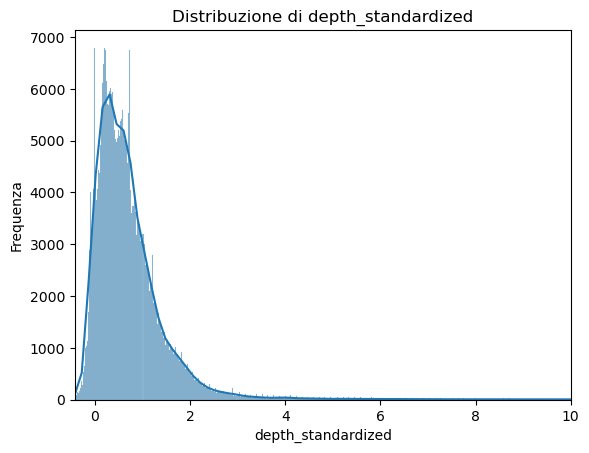

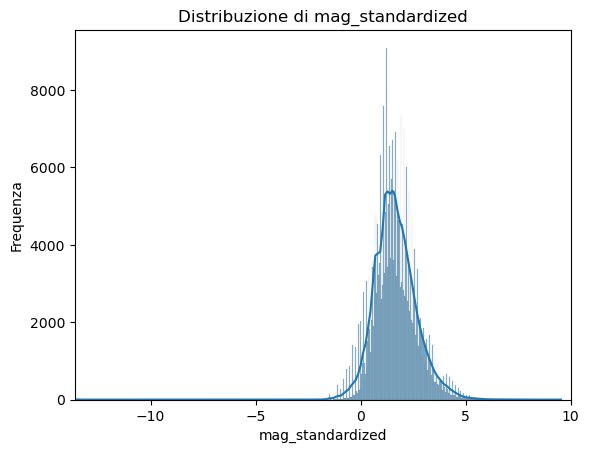

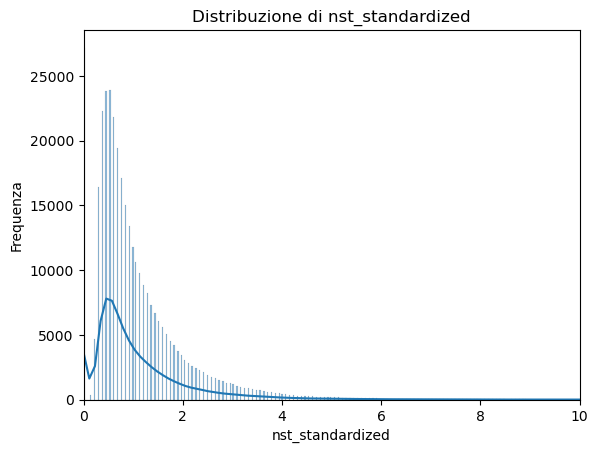

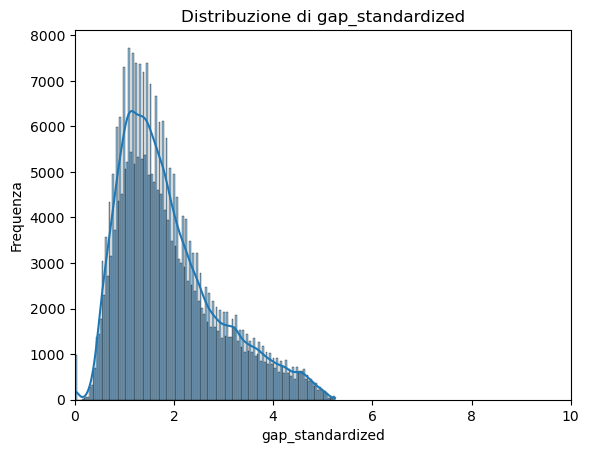

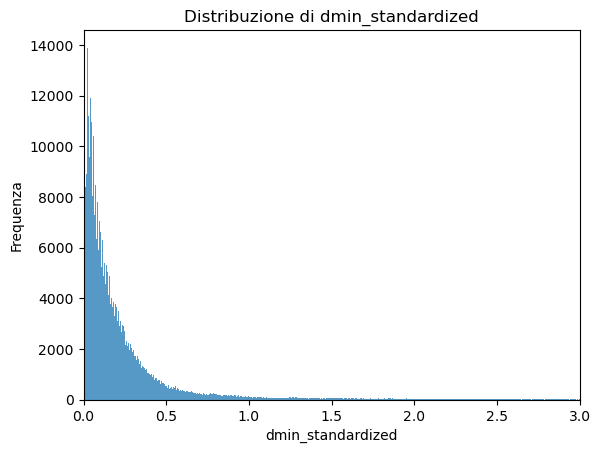

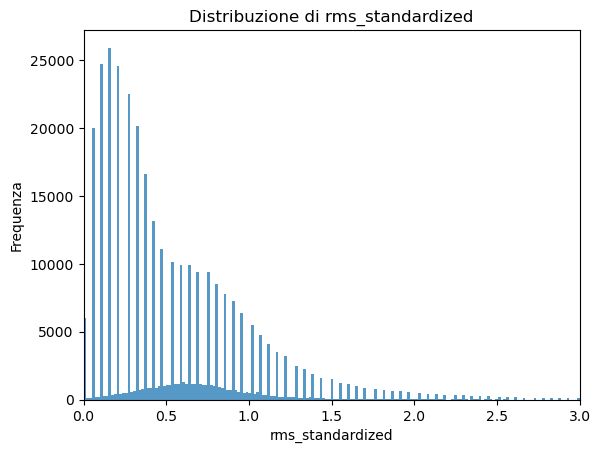

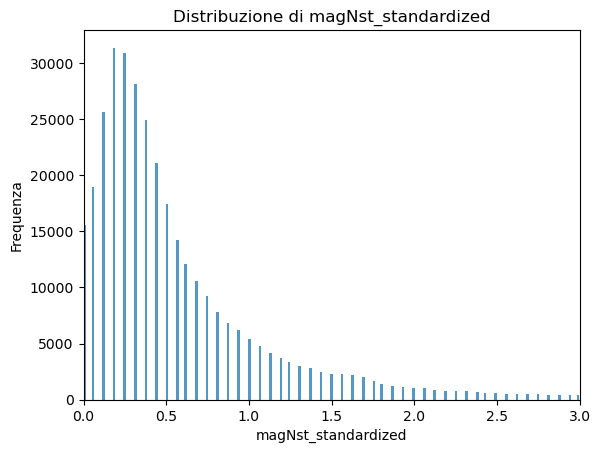

In [21]:
# Visualizzazione con Matplotlib e Seaborn
for column in pandas_df:
    
    # Imposto i limiti sull'asse x in base alle variabili e distinguo due casi.
    if column == 'magNst_standardized' or column == 'dmin_standardized' or column == 'rms_standardized':
        min_val = pandas_df[column].min()
        max_val = 3 # pandas_df[column].max()
        # Creo l'istogramma con KDE
        sns.histplot(data=pandas_df, x=column, kde=False)
    else:
        min_val = pandas_df[column].min()
        max_val = 10 # pandas_df[column].max()
        sns.histplot(data=pandas_df, x=column, kde=True)

    # Imposto i limiti dell'asse x specifici per la colonna
    plt.xlim(min_val, max_val)

    plt.title("Distribuzione di " + column)
    plt.ylabel("Frequenza")
    plt.xlabel(column)

    # Salvo l'immagine sul path predefinito
    plt.savefig(images_path + column + '.png')
    
    plt.show()

### Correlazioni tra le variabili numeriche

In [22]:
# Lista delle colonne da correlare
columns_to_correlate = ['latitude', 'longitude', 'depth', 'mag', 'nst', 'gap', 'dmin',
                        'rms', 'horizontalError', 'depthError', 'magError', 'magNst']

# Rimuovo le righe con valori nulli nelle colonne specificate
df_no_null = df.dropna(subset=columns_to_correlate)

# Seleziono solo le colonne numeriche
df_numeric = df_no_null.select(*columns_to_correlate)

# Preparo il vector assembler al fine di calcolare la matrice di correlazione con Spark
assembler = VectorAssembler(inputCols=columns_to_correlate, outputCol="features")
df_vector = assembler.transform(df_numeric).select("features")

# Calcola la matrice di correlazione
# qui si puo' usare head()[0] oppure collect()[0][0], entrambe prendono il primo elemento della prima riga.
# diciamo che head()[0] è piu' efficiente, perchè recupera solo la prima riga, ma collect()[0][0] rende piu' leggibile il codice.
correlation_matrix = Correlation.corr(df_vector, "features").head()[0].toArray()

# Come al solito converto il tutto in un dataframe di Pandas al solo scopo raffigurativo
pd_corr_matrix = pd.DataFrame(correlation_matrix, index=columns_to_correlate, columns=columns_to_correlate)

# Stampo le dimensioni della matrice di correlazione, ovviamente sarà quadrata
print("Dimensioni della matrice di correlazione:", pd_corr_matrix.shape)

pd_corr_matrix

Dimensioni della matrice di correlazione: (12, 12)


,latitude,longitude,depth,mag,nst,gap,dmin,rms,horizontalError,depthError,magError,magNst
latitude,1.000000,-0.258416,-0.304609,-0.257408,-0.165925,-0.045803,-0.080244,-0.080240,-0.040037,-0.060953,-0.118730,-0.159552
longitude,-0.258416,1.000000,0.371392,0.167499,-0.061885,0.180558,0.157409,0.081720,0.102808,0.114238,-0.083184,0.010459
depth,-0.304609,0.371392,1.000000,0.236652,0.052015,0.196680,0.168120,0.107001,0.123505,-0.015259,-0.038874,0.054282
mag,-0.257408,0.167499,0.236652,1.000000,0.398344,-0.011630,0.162938,0.164538,0.087353,0.133134,0.091388,0.400810
nst,-0.165925,-0.061885,0.052015,0.398344,1.000000,-0.482543,-0.037975,0.067352,-0.159812,-0.135475,0.073958,0.668463
gap,-0.045803,0.180558,0.196680,-0.011630,-0.482543,1.000000,0.195113,0.065982,0.359662,0.279330,-0.038697,-0.249840
dmin,-0.080244,0.157409,0.168120,0.162938,-0.037975,0.195113,1.000000,0.112947,0.165049,0.171761,-0.005957,-0.000339
rms,-0.080240,0.081720,0.107001,0.164538,0.067352,0.065982,0.112947,1.000000,0.412600,0.235016,0.025993,0.094475
horizontalError,-0.040037,0.102808,0.123505,0.087353,-0.159812,0.359662,0.165049,0.412600,1.000000,0.317070,-0.007373,-0.070030
depthError,-0.060953,0.114238,-0.015259,0.133134,-0.135475,0.279330,0.171761,0.235016,0.317070,1.000000,0.027036,-0.012635


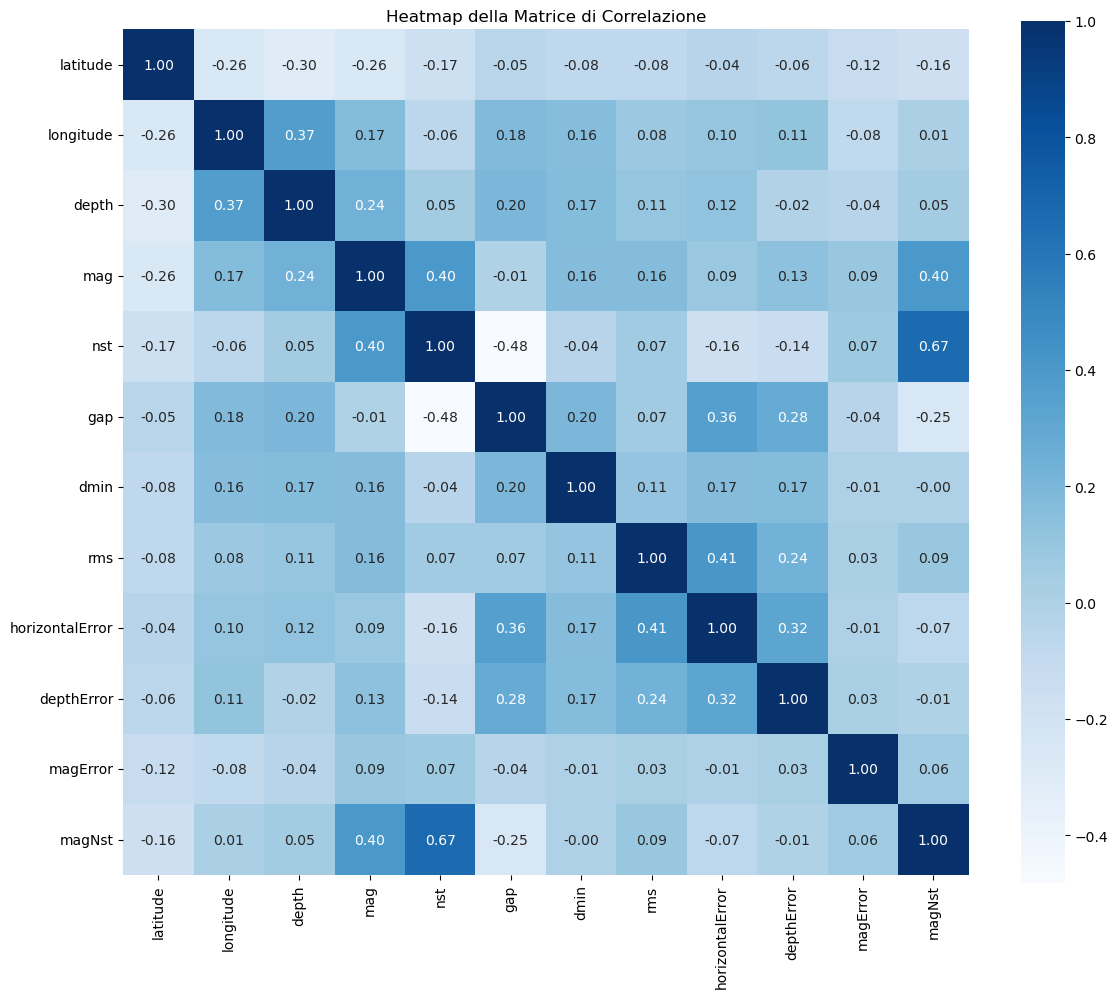

In [23]:
# Heatmap utilizzando Seaborn e Matplotlib
plt.figure(figsize=(12, 10))
sns.heatmap(pd_corr_matrix, annot=True, fmt=".2f", square=True, cmap='Blues')
plt.title("Heatmap della Matrice di Correlazione")

plt.tight_layout()  
plt.savefig(images_path + 'correlation_matrix.png')
plt.show()


## Data Preparation

In [24]:
# Univariate Outliers detection and removal using IQR method
"""
from pyspark.sql.functions import col, abs

remove_outliers_from_these = ['depth', 'mag', 'nst', 'gap', 'dmin', 'rms', 'magNst']
threshold_ = 10

# utilizzaimo approxQuantile di pyspark per semplificarci notevolmente la vita
for column in remove_outliers_from_these:
    # Calcola Q1 e Q3 e l'IQR
    quantiles = df.stat.approxQuantile(column, [0.25, 0.75], 0.0)
    Q1, Q3 = quantiles[0], quantiles[1]
    IQR = Q3 - Q1

    # Definisce i limiti per determinare gli outliers
    lower_bound = Q1 - threshold_ * IQR
    upper_bound = Q3 + threshold_ * IQR

    # Filtra gli outliers
    df = df.filter((col(column) >= lower_bound) & (col(column) <= upper_bound))
"""

"""
Ho provato ad eliminare gli outliers in questo modo, ma dopo aver eseguito molteplici tentativi, 
mi sono accorto che tutto cio' portava all'eliminazione di tantissimi terremoti registrati nel mondo. 
Restavano solo quelli registrati nella west coast americana, in paticolare negli stati di California e Nevada.
Terremoti registrati in europa, asia e oceania andrebbero persi del tutto, ergo è meglio non rimuovere gli outliers in questo modo e 
utilizzare il dataset cosi come è, eliminando ovviamente altri tipi di inconsistenze ed errori che però non 
non vanno ad intaccare il significato del dataset: illustrare i terremoti avvenuti NEL MONDO, dal 1970 al 2020.
"""

"\nHo provato ad eliminare gli outliers in questo modo, ma dopo aver eseguito molteplici tentativi, \nmi sono accorto che tutto cio' portava all'eliminazione di tantissimi terremoti registrati in altre aree \ngeografiche oltre all'america in generale che è pienissima. \nSe procedessi con tale metodo rimarrebbero solo terremoti in america e in altre piccole parti ad alta concentrazione, \nterremoti registrati in europa, asia e oceania andrebbero persi del tutto, ergo è meglio non rimuovere gli outliers in questo modo e \nutilizzare il dataset cosi come è, eliminando ovviamente altri tipi di inconsistenze ed errori che però non \nnon vanno ad intaccare il significato del dataset: illustrare i terremoti avvenuti NEL MONDO, dal 1970 al 2020.\n"

#### Cleaning phase

In [25]:
# Rimozione delle seguenti colonne:
df = df.drop('_c0', 'status', 'id', 'magError', 'horizontalError', 'depthError', 'locationSource', 'magSource', 'net')

In [26]:
# Per visualizzare il risultato e triggerare la rimozione delle colonne di cui sopra
# ricordiamo che ilo coportamento default di Spark è Lazy, volendo si potrebbe anche farlo funzionare eager
df.show()

+--------------------+------------------+-------------------+-----+----+-------+----+-----+-------------------+----+--------------------+--------------------+------------+------+
|                time|          latitude|          longitude|depth| mag|magType| nst|  gap|               dmin| rms|             updated|               place|        type|magNst|
+--------------------+------------------+-------------------+-----+----+-------+----+-----+-------------------+----+--------------------+--------------------+------------+------+
| 1970-01-01 01:00:00|37.003501899999996|       -117.9968338|  0.0| 0.0|     mh| 0.0| NULL|               NULL|NULL|2016-04-02 22:22:...|29km NE of Indepe...|  sonic boom|   0.0|
| 1970-01-01 01:00:00|35.642787899999995|       -120.9336014|  5.0|1.99|     mh| 2.0| NULL|               NULL|NULL|2016-01-29 02:43:...|11km SSW of Lake ...|  earthquake|   0.0|
| 1970-01-01 01:00:00|        34.1645203|-118.18503570000001|  0.0| 0.0|     mh|NULL| NULL|              

In [27]:
# RIMOZIONE DEI DUPLICATI

# conto le righe nel dataframe prima della rimozione
rows_before_dups_removal = df.count()
print(f'Before removing duplicates, the dataset had {rows_before_dups_removal} rows.')

# rimuovo i duplicati
df = df.dropDuplicates()

# conto le righe totali dopo la rimozione
rows_after_dups_removal = df.count()
print(f'After duplicates removal, we have {rows_after_dups_removal} rows.')

# calcolo la percentuale dei duplicati rimossi rispetto al totale
percentage_of_removed_dups = ((rows_before_dups_removal - rows_after_dups_removal) / rows_before_dups_removal) * 100
print(f'Percentage of duplicate rows removed: {percentage_of_removed_dups:.2f}%')

Before removing duplicates, the dataset had 3272774 rows.


After duplicates removal, we have 3256955 rows.
Percentage of duplicate rows removed: 0.48%


In [28]:
# RIMUOVO LE INCONSISTENZE:
# la variabile depth non puo' avere valori negativi o uguali a zero. Un valore di zero indica che 
# l'epicentro del terremoto si trova proprio sulla superficie terrestre il che è statisticamente quasi impossibile

from pyspark.sql.functions import col
# Filtro per rimuovere righe con 'depth' negativo
df = df.filter(col('depth') > 0)

# Filtro per rimuovere righe con 'mag' negativo
df = df.filter(col('mag') > 0)

print(f'rimossi tutti i valori negativi e pari a nel dataset, restano {df.count()} righe')

rimossi tutti i valori negativi e pari a nel dataset, restano 2805339 righe


In [29]:
# Rimozione righe null da colonne significative:
# significative sia per la loro importanza che per le correlazioni con variabili che entraranno in gioco
# nelle fasi successive
df = df.filter(col('mag').isNotNull())
df = df.filter(col('depth').isNotNull())
df = df.filter(col('magType').isNotNull())
df = df.filter(col('rms').isNotNull())
df = df.filter(col('place').isNotNull())
print(f'rimosse tutte le righe null dalle variabili numeriche depth, mag, rms e dalla variabile categorica magType')
print(f'il dataframe contiene {df.count()} righe')

rimosse tutte le righe null dalle variabili numeriche depth, mag, rms e dalla variabile categorica magType


il dataframe contiene 2622247 righe


In [30]:
# nella colonna magType ci sono valori come md e ml che sono scritti in maiuscolo, 
# faremo in modo che tutti i valori siano scritti in minuscolo accorpandoli
df = df.withColumn("magType", lower(df["magType"]))

In [31]:
# Accorpiamo tutti i valori della colonna magType che non siano ml o md in other
# tutto cio' allo scopo d semplificare il modello e agevolare la classificazione, meno categorie rendono
# il modello meno complesso e piu' facile da interpretare. Poi ovviamente le 3 categorie sono anche abbastanza equilibrate
df = df.withColumn("magType", when(col("magType").isin(["ml", "md"]), col("magType")).otherwise("other"))


In [32]:
# visualizziamo i valori unici e quanti sono della colonna magType
magType_counts = df.groupBy("magType").count()
magType_counts = magType_counts.orderBy(desc("count"))

In [33]:
magType_counts.show()
# da cui vediamo che le classi sono abbastanza equilibrate tra loro

+-------+------+
|magType| count|
+-------+------+
|     md|953365|
|     ml|945033|
|  other|723849|
+-------+------+


In [34]:
# Filtra il DataFrame per mantenere solo le righe dove 'type' è 'earthquake'
# è inutile mantenere righe dove meno dell'uno per cento sono altri tipi di fenomeni, concentriamoci
# solo sui terremoti che sono rappresentati dal 99% del dataset e poi possiamo così anche eliminare la colonna earthquake
# dal momento che tutti i punti del dataset sono relativi ai terremoti.
df = df.filter(df['type'] == 'earthquake')

In [35]:
# dopo aver filtrato solo le righe che riguardano i terremoti possiamo eliminare la colonna earthquake
df = df.drop('type')

In [36]:
df.show()

+--------------------+------------------+-------------------+------------------+----+-------+----+-----+--------------------+----+--------------------+--------------------+------+
|                time|          latitude|          longitude|             depth| mag|magType| nst|  gap|                dmin| rms|             updated|               place|magNst|
+--------------------+------------------+-------------------+------------------+----+-------+----+-----+--------------------+----+--------------------+--------------------+------+
|1971-12-08 07:43:...|47.842833299999995|-119.62116670000002|             6.518| 1.6|     md| 7.0|301.0|              0.4872|0.12|2016-07-25 01:51:...|          Washington|   7.0|
|1972-11-15 10:11:...|        46.8286667|           -119.473|1.3880000000000001| 0.9|     md| 8.0|194.0|             0.03549|0.12|2016-07-25 01:57:...|          Washington|   8.0|
|1972-11-21 10:27:...|        34.0848333|-116.78233329999999|               6.0|2.83|     ml| 9.0| 8

In [37]:
# Vediamo dopo aver applicato queste modifiche quanti MISSING VALUES RESTANO ancora ndel dataframe e stampiamoli in ordine non crescente:

# Calcolo i valori mancanti per ogni colonna
missing_values_df = df.select([count(when(isnull(c), c)).alias(c) for c in df.columns])

# Calcolo la percentuale di valori nulli corrispondenti
percents_df = df.select(
    [(count(when(isnull(c), c)) / lit(df.count()) * 100).alias(c)
     for c in df.columns])

# Raccolgo i risultati in liste Python
missing_values = missing_values_df.collect()[0].asDict()
percents = percents_df.collect()[0].asDict()

# Creo un dizionario che associa il numero di valori nulli con la loro percentuale
missing_values_to_percents = {col: (missing_values[col], percents[col]) for col in missing_values}

# Trasformo il dizionario in una lista di tuple
data_for_df = [(col, *vals) for col, vals in missing_values_to_percents.items()]

# Creo un dataframe Pandas dai dati
df_as_dict = pd.DataFrame(data_for_df, columns=['Feature', 'Total Nulls', 'Percentage Nulls'])

df_as_dict.sort_values(ascending=False, by='Percentage Nulls')

,Feature,Total Nulls,Percentage Nulls
8,dmin,979936,37.580170
6,nst,727659,27.905444
7,gap,652113,25.008284
12,magNst,605695,23.228171
0,time,0,0.000000
1,latitude,0,0.000000
2,longitude,0,0.000000
3,depth,0,0.000000
4,mag,0,0.000000
5,magType,0,0.000000


#### Imputazioni valori mancanti di 'dmin' e 'gap' utilizzando la media

In [38]:
# IMPUTAZIONE DI 'dmin' e 'gap' con la loro media
from pyspark.ml.feature import Imputer
imputer = Imputer(
    inputCols=["dmin", "gap"],
    outputCols=["dmin", "gap"]
).setStrategy("mean")  

df  = imputer.fit(df).transform(df)

In [39]:
df.count()

2607588

In [40]:
df.show()

+--------------------+------------------+-------------------+------------------+----+-------+----+-----+--------------------+----+--------------------+--------------------+------+
|                time|          latitude|          longitude|             depth| mag|magType| nst|  gap|                dmin| rms|             updated|               place|magNst|
+--------------------+------------------+-------------------+------------------+----+-------+----+-----+--------------------+----+--------------------+--------------------+------+
|1971-12-08 07:43:...|47.842833299999995|-119.62116670000002|             6.518| 1.6|     md| 7.0|301.0|              0.4872|0.12|2016-07-25 01:51:...|          Washington|   7.0|
|1972-11-15 10:11:...|        46.8286667|           -119.473|1.3880000000000001| 0.9|     md| 8.0|194.0|             0.03549|0.12|2016-07-25 01:57:...|          Washington|   8.0|
|1972-11-21 10:27:...|        34.0848333|-116.78233329999999|               6.0|2.83|     ml| 9.0| 8

### Imputazione colonna 'nst' usando la REGRESSIONE LINEARE

In [41]:
# IMPUTAZIONE valori null per l'attributo a valori continui 'nst'
# effettueremo l'imputazione con l'ausilio delle seguenti colonne:
columns_to_use = ['latitude', 'longitude', 'depth', 'mag', 'rms']

# preparo il VectorAssembler, arma necessaria e fondamentale!
# esso è utilizzato per combinare le colonne selezionate in un unico vettore di caratteristiche che chiamo 'features'
# tale vettore poi sarà passato ai vari modelli.
assembler = VectorAssembler(inputCols=columns_to_use, outputCol="features")

# standardizzo le variabili da utilizzare per la regressione lineare
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures")

# CREAZIONE E ADDESTRAMENTO DEL MODELLO:
target = 'nst'
lr = LinearRegression(featuresCol="scaledFeatures", labelCol=target)

# combino le fasi di assemblaggio, standardizzazione e regressione lineare in una pipeline:
pipeline = Pipeline(stages=[assembler, scaler, lr])

# addestramento del modello sui dati non nulli
train_df = df.filter(df.nst.isNotNull())
model = pipeline.fit(train_df)

# Applico il modello a tutto il dataframe
# Cioè sto utilizzando il modello per generare previsioni su tutto il dataframe inclusi i record con valori nulli per 'nst'.
# Anche se il modello viene applicato a tutti i record, i valori esistenti e non nulli di 'nst' 
# vengono mantenuti, e solo i valori nulli vengono sostituiti con le previsioni del modello.
full_predictions = model.transform(df) #  vienew creata una colonna a default chiamata 'prediction'

# Sostituisco i valori null di 'nst' con le previsioni
# Utilizzo la funzione withColumn per creare una nuova colonna ('nst_imputed') nel dataframe.
# La funzione when è utilizzata per controllare se il valore originale di 'nst' è nullo. 
# Se la risposta è affermativa, utilizzo il valore previsto dal modello (full_predictions["prediction"]).
# Se invece la risposta è negativa, cioè il valore originale di 'nst' non è nullo, allora si mantiene il valore originale 
df_imputed = full_predictions.withColumn(
    "nst_imputed",
    when(full_predictions["nst"].isNull(), full_predictions["prediction"])
    .otherwise(full_predictions["nst"])
)

# Rimuovo le colonne create nei vari steps non più necessarie
df_final = df_imputed.drop("features", "scaledFeatures", "prediction")

# Rimuovo la colonna 'nst' originale contenente i valori null
df_final = df_final.drop("nst")

# Rinomino 'nst_imputed' in 'nst'
df_final = df_final.withColumnRenamed("nst_imputed", "nst")


In [42]:
df_final.show()

+--------------------+------------------+-------------------+------------------+----+-------+-----+--------------------+----+--------------------+--------------------+------+----+
|                time|          latitude|          longitude|             depth| mag|magType|  gap|                dmin| rms|             updated|               place|magNst| nst|
+--------------------+------------------+-------------------+------------------+----+-------+-----+--------------------+----+--------------------+--------------------+------+----+
|1971-12-08 07:43:...|47.842833299999995|-119.62116670000002|             6.518| 1.6|     md|301.0|              0.4872|0.12|2016-07-25 01:51:...|          Washington|   7.0| 7.0|
|1972-11-15 10:11:...|        46.8286667|           -119.473|1.3880000000000001| 0.9|     md|194.0|             0.03549|0.12|2016-07-25 01:57:...|          Washington|   8.0| 8.0|
|1972-11-21 10:27:...|        34.0848333|-116.78233329999999|               6.0|2.83|     ml| 87.0| 

### Imputazione colonna magNst utilizzando un DecisionTreeRegressor

In [43]:
# Imputazione colonna magNst utilizzando un DecisionTreeRegressor
target = 'magNst'
columns_to_use = ['latitude', 'longitude', 'depth', 'mag', 'rms']

assembler = VectorAssembler(inputCols=columns_to_use, outputCol="features")

# nel caso di un decision tree regressor la standardizzazione delle variabili non è necessaria
# A differenza dei modelli lineari o di altri algoritmi come SVM o reti neurali, 
# gli alberi decisionali non sono sensibili alla scala delle variabili.

dt = DecisionTreeRegressor(featuresCol="features", labelCol=target)
pipeline = Pipeline(stages=[assembler, dt])

train_df = df_final.filter(df_final.magNst.isNotNull())
model = pipeline.fit(train_df)

full_predictions = model.transform(df_final)
df_imputed = full_predictions.withColumn(
    "magNst_imputed",
    when(full_predictions["magNst"].isNull(), full_predictions["prediction"])
    .otherwise(full_predictions["magNst"])
)

df_final = df_imputed.drop("features", "prediction")

df_final = df_final.drop("magNst").withColumnRenamed("magNst_imputed", "magNst")

In [44]:
df_final.show()

+--------------------+------------------+-------------------+------------------+----+-------+-----+--------------------+----+--------------------+--------------------+----+------+
|                time|          latitude|          longitude|             depth| mag|magType|  gap|                dmin| rms|             updated|               place| nst|magNst|
+--------------------+------------------+-------------------+------------------+----+-------+-----+--------------------+----+--------------------+--------------------+----+------+
|1971-12-08 07:43:...|47.842833299999995|-119.62116670000002|             6.518| 1.6|     md|301.0|              0.4872|0.12|2016-07-25 01:51:...|          Washington| 7.0|   7.0|
|1972-11-15 10:11:...|        46.8286667|           -119.473|1.3880000000000001| 0.9|     md|194.0|             0.03549|0.12|2016-07-25 01:57:...|          Washington| 8.0|   8.0|
|1972-11-21 10:27:...|        34.0848333|-116.78233329999999|               6.0|2.83|     ml| 87.0| 

In [45]:
# A questo punto vediamo se ci sono ancora valori null nel dataframe
counter = 0
for col_name in df_final.columns:
    # Conto il numero di valori null in ogni colonna
    null_count = df_final.filter(df_final[col_name].isNull()).count()

    if null_count > 0:
        print(f"La colonna '{col_name}' ha {null_count} valori null.")
        counter = counter + 1

if counter == 0:
    print('nessuna variabile ha valori null!')

nessuna variabile ha valori null!


In [46]:
df_final.printSchema()

root
 |-- time: timestamp (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)
 |-- depth: double (nullable = true)
 |-- mag: double (nullable = true)
 |-- magType: string (nullable = true)
 |-- gap: double (nullable = true)
 |-- dmin: double (nullable = true)
 |-- rms: double (nullable = true)
 |-- updated: timestamp (nullable = true)
 |-- place: string (nullable = true)
 |-- nst: double (nullable = true)
 |-- magNst: double (nullable = true)


In [47]:
# Mi ricreo la matrice di correlazione per vedere i cambiamenti nelle correlazìoni dopo le varie imputazioni
numeric_columns_remained = ['latitude', 'longitude', 'depth', 'mag', 'gap', 'dmin', 'rms', 'nst', 'magNst']
df_selected = df_final.select(*numeric_columns_remained)

assembler = VectorAssembler(inputCols=numeric_columns_remained, outputCol="features")
df_vector = assembler.transform(df_selected).select("features")

correlation_matrix = Correlation.corr(df_vector, "features").head()[0].toArray() 
pd_corr_matrix = pd.DataFrame(correlation_matrix, index=numeric_columns_remained, columns=numeric_columns_remained)

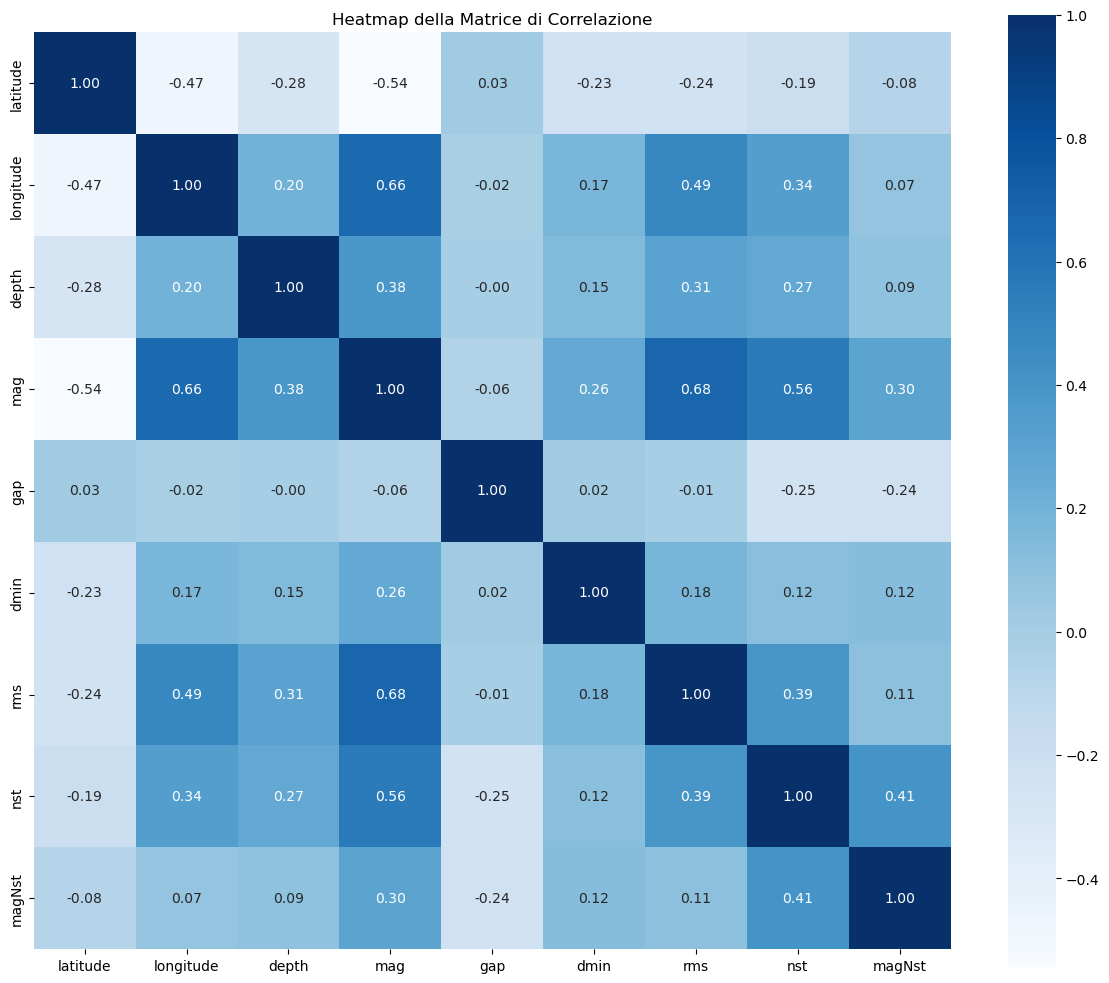

In [54]:
# Visualizzo la heatmap utilizzando Seaborn e Matplotlib
plt.figure(figsize=(12, 10))  
sns.heatmap(pd_corr_matrix, annot=True, fmt=".2f", square=True, cmap='Blues')
plt.title("Heatmap della Matrice di Correlazione")

plt.tight_layout()  
plt.savefig(images_path + 'correlation_matrix_after_imputation.png')
plt.show()


In [49]:
df_final.printSchema()

root
 |-- time: timestamp (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)
 |-- depth: double (nullable = true)
 |-- mag: double (nullable = true)
 |-- magType: string (nullable = true)
 |-- gap: double (nullable = true)
 |-- dmin: double (nullable = true)
 |-- rms: double (nullable = true)
 |-- updated: timestamp (nullable = true)
 |-- place: string (nullable = true)
 |-- nst: double (nullable = true)
 |-- magNst: double (nullable = true)


In [50]:
df_final.show()

+--------------------+------------------+-------------------+------------------+----+-------+-----+--------------------+----+--------------------+--------------------+----+------+
|                time|          latitude|          longitude|             depth| mag|magType|  gap|                dmin| rms|             updated|               place| nst|magNst|
+--------------------+------------------+-------------------+------------------+----+-------+-----+--------------------+----+--------------------+--------------------+----+------+
|1971-12-08 07:43:...|47.842833299999995|-119.62116670000002|             6.518| 1.6|     md|301.0|              0.4872|0.12|2016-07-25 01:51:...|          Washington| 7.0|   7.0|
|1972-11-15 10:11:...|        46.8286667|           -119.473|1.3880000000000001| 0.9|     md|194.0|             0.03549|0.12|2016-07-25 01:57:...|          Washington| 8.0|   8.0|
|1972-11-21 10:27:...|        34.0848333|-116.78233329999999|               6.0|2.83|     ml| 87.0| 

In [51]:
df.count()

2607588

In [52]:
# Scrivo tutta la preparazione e pulizia del dataframe effettuata in un file .csv unico
df_final.coalesce(1).write.format("csv") \
    .option("header", "true") \
    .mode("overwrite") \
    .option("sep", ",") \
    .save(output_dataset_path)

In [53]:
# Termino la sessione Spark rilasciando le risorse occupate
spark.stop()

In [ ]:
# seguono due file sul clustering:
# il primo, spark_clustering_exploartion.ipynb, utilizza 9 colonne per il clustering ed effettua 
# una analisi specifica di ogni gruppo in base alle statistiche (media di ogni cluster ecc...)

# il secondo, spark_clustering_geographical.ipynb, è piu' un esercizio di stile 
# in cui, utilizzando solo latitudine e longitudine nella loro scala originale, è possibile 
# visualizzare i vari clusters direttamente sulla mappa mondiale ottenuta con Folium.